# 📡 Имитационное моделирование RFID системы без коллизий

В этом блокноте проводится **имитационное моделирование UHF RFID-системы** с одним считывателем и одной меткой **без коллизий**.

📍 **Описание сценария:**
Модель воспроизводит ситуацию из блокнота `3d_model_of_system`, где RFID-считыватель закреплён на беспилотнике (БПЛА), движущемся равномерно и прямолинейно над полем с одной меткой. Вдоль движения расположена стена, от которой отражается сигнал, из-за чего появляется явление многолучевого распространения.

---

## 🎯 Цель моделирования

Воссоздать ключевые графики из магистерской диссертации:
1. **📈 Зависимость вероятности чтения банка `USER` от скорости движения считывателя**  
   (построены два графика для разных значений `reader_offset`);
2. **📈 Зависимость вероятности от высоты полёта считывателя** при разных расстояниях до стены;
3. **📈 Зависимость от мощности считывателя** для разных высот;
4. **📈 Зависимость от длины передаваемых данных (TID/User)**:
   - Один график — для разных мощностей;
   - Второй — для разных пар `Tari` и `M`;
5. **📈 Зависимость от расстояния метки до стены** при разных высотах считывателя.

---

## 🔧 Терминология

- **Имитационка** — один запуск имитационной модели, даёт одну точку на графике.
- **Сет** — параллельный запуск имитационок, в которых меняется один параметр. Даёт одну **кривую**.
- **График** — изображение с несколькими кривыми. Каждая кривая получается из отдельного сета. Кривые отличаются параметрами модели, но объединены одной переменной по оси абсцисс.

---

## 💾 Сохранение результатов

Поскольку моделирование длительное (десятки минут), результаты можно сохранять в `.json`. При построении графиков доступны два режима:
- **♻️ Использовать сохранённые данные** (быстро, но неактуально);
- **🔁 Перезапустить моделирование** для получения свежих результатов.

---

## ⚠️ Рекомендации по `num_tags`

| Значение  | Назначение                                                  | Время (M3 Pro)     |
|-----------|-------------------------------------------------------------|--------------------|
| `10`      | Проверка работоспособности кода                             | ~3–5 секунд        |
| `40–50`   | Первичный анализ поведения системы                          | ~10–20 секунд      |
| `500–1000`| Рабочие графики для методичек, устранение флуктуаций        | ~3–5 минут         |
| `2000–6000`| Научные публикации, диссертация (максимальное сглаживание) | >10 минут          |

---

### Импорт необходимых модулей

In [1]:
import copy
import numpy as np

from pysim.experiments.utility.rfid_helper import calculate_simulations, plot_simulations_results
from pysim.models.rfid.params import default_params

In [2]:
SAVE_FIG = True         # Сохранять ли изображения
SAVE_RESULTS = True     # Сохранять ли результаты в JSON
USE_JSON = False          # Использовать ли результаты из JSON

IMG_DIRECTORY = "rfid/single_tag/"
JSON_DIRECTORY = "../results/result_jsons/rfid/single_tag/"

## 📈 Зависимость времени и вероятности чтения банка памяти `USER` от скорости

В этом эксперименте изучается, как **скорость движения считывателя** влияет на время и вероятность успешного чтения данных из банка `USER`.

🔍 **Вариации параметров:**
- Изменяется переменная `speed` в диапазоне от **5 до 70 км/ч** с шагом 2.5 км/ч.
- Построено **две серии графиков**:
  1. Для расстояния от стены `reader_offset`, равного значению по умолчанию;
  2. Для `reader_offset = 1.0 м`.

🎛 **Перебираемые параметры модуляции (`M`) и длительности импульса (`Tari`):**
- M = `FM0`, Tari = 6.25 мкс
- M = `FM0`, Tari = 18.75 мкс
- M = `Miller-2`, Tari = 12.5 мкс
- M = `Miller-4`, Tari = 6.25 мкс
- M = `Miller-8`, Tari = 25.0 мкс

📌 Остальные параметры (мощность, высота, расстояние метки и т.д.) — фиксированы.

📉 Каждая кривая на графике соответствует своей паре `(Tari, M)` при фиксированном `reader_offset`.

В некоторых случаях при низких значениях скорости может возникать явление коллизий, в результате чего вероятность идентификации значительно снижается.

### ⚙️ Параметры для запуска моделирования

In [14]:
# Переменная по оси абсцисс
speed_variable = np.arange(20.0, 72.5, 2.5)
# Параметры для разных кривых
coding_params = [
    # {"encoding": "FM0", "tari": 6.25},
    {"encoding": "FM0", "tari": 18.75},
    {"encoding": "M2", "tari": 12.5},
    {"encoding": "M4", "tari": 6.25},
    # {"encoding": "M8", "tari": 25.0},
]

# Каждый словарь в list - это набор входных данных для одной кривой
# --- Данные для первого графика ---
speed_params_list = []
for coding_params_item in coding_params:
    speed_params_list.append({
        "tari": coding_params_item["tari"],
        "encoding": coding_params_item["encoding"],
        "tid_word_size": default_params.tid_word_size,
        "power": default_params.power_dbm,
         # "num_tags": default_params.num_tags,
        "num_tags": 150,
        "reader_offset": default_params.reader_offset,
        "tag_offset": default_params.tag_offset,
        "altitude": 4,
        "useadjust": default_params.useadjust,
        "q": 0,
    })

# --- Данные для второго графика ---
new_reader_offset = 1.0
speed_params_list_2 = []
for params in speed_params_list:
    new_params = copy.deepcopy(params)
    new_params["reader_offset"] = new_reader_offset
    speed_params_list_2.append(new_params)

### 💾 Получение результатов

In [15]:
key_name = lambda params: f"M = {params['encoding']}, Tari = {params['tari']} мкс"

In [16]:
# --- Первый график ---
speed_result = calculate_simulations(
    variable="speed",
    variable_values=speed_variable,
    params_list=speed_params_list,
    key_fn=key_name,
    use_json=USE_JSON,
    save_results=SAVE_RESULTS,
    json_directory=JSON_DIRECTORY,
    file_name="speed.json"
)
# Моделирование на M3 Pro с "num_tags": 2000:
# Моделирование по скоростям: 100%|██████████| 5/5 [41:43<00:00, 500.79s/it]

Моделирование по переменной speed: 100%|██████████| 3/3 [00:58<00:00, 19.66s/it]


In [17]:
# --- Второй график ---
speed_result_2 = calculate_simulations(
    variable="speed",
    variable_values=speed_variable,
    params_list=speed_params_list_2,
    key_fn=key_name,
    use_json=False,
    save_results=SAVE_RESULTS,
    json_directory=JSON_DIRECTORY,
    file_name="speed_2.json"
)
# Моделирование на M3 Pro с "num_tags": 750:
# Моделирование по переменной speed: 100%|██████████| 5/5 [16:37<00:00, 199.51s/it]

Моделирование по переменной speed: 100%|██████████| 3/3 [01:02<00:00, 20.83s/it]


### 🖼️ Построение графиков для вероятности чтения банка памяти USER

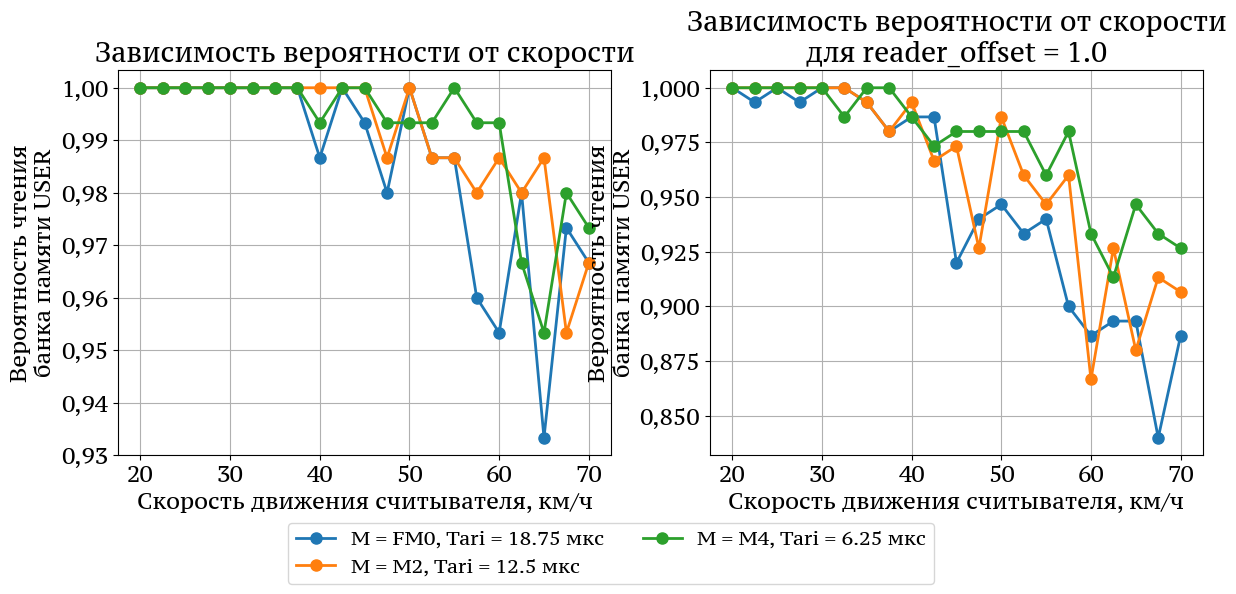

In [18]:
plot_simulations_results(
    results_list=[
        speed_result["read_user_probs"],
        speed_result_2["read_user_probs"]
    ],
    labels_list=[
    [key_name(params) for params in coding_params],
    [key_name(params) for params in coding_params]
    ],
    titles=[
        "Зависимость вероятности от скорости",
        f"Зависимость вероятности от скорости\nдля reader_offset = {new_reader_offset}"
    ],
    x_variable=speed_variable,
    x_label="Скорость движения считывателя, км/ч",
    unified_legend=True,
    image_name="Speed probs",
    save_fig=SAVE_FIG,
    image_directory=IMG_DIRECTORY,
)

### 🖼️ Построение графиков для времени чтения банка памяти USER

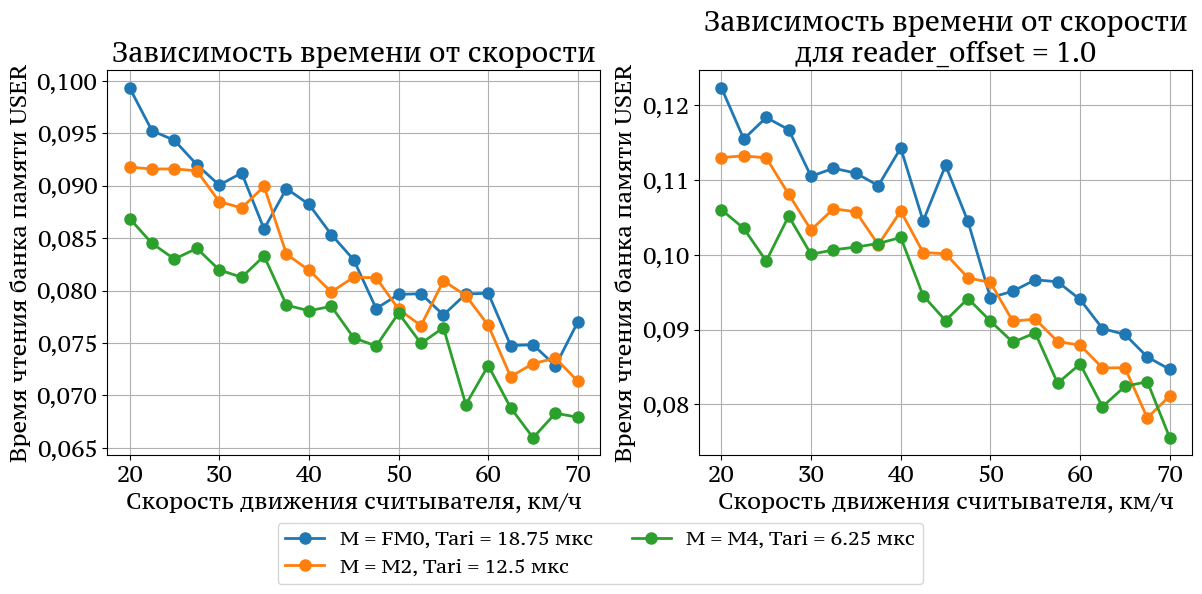

In [19]:
plot_simulations_results(
    results_list=[
        speed_result["times_count"],
        speed_result_2["times_count"]
    ],
    labels_list=[
    [key_name(params) for params in coding_params],
    [key_name(params) for params in coding_params]
    ],
    titles=[
        "Зависимость времени от скорости",
        f"Зависимость времени от скорости\nдля reader_offset = {new_reader_offset}"
    ],
    x_variable=speed_variable,
    x_label="Скорость движения считывателя, км/ч",
    y_label="Время чтения банка памяти USER",
    unified_legend=True,
    image_name="Speed times",
    save_fig=SAVE_FIG,
    image_directory=IMG_DIRECTORY,
)

## 📈 Зависимость вероятности чтения банка памяти `USER` от высоты полёта считывателя

В этом эксперименте исследуется, как **высота полёта считывателя (`altitude`)** влияет на вероятность чтения информации из банка `USER`.

🔍 **Вариации параметров:**
- Изменяется переменная `altitude` от **0.5 до 7.0 м** с шагом 0.5 м.
- Построены кривые для разных значений расстояния `reader_offset` от стены (которая отражает сигнал).

📏 **Перебираемые значения `reader_offset`:**
- 0.5 м
- 1.0 м
- 1.5 м
- 2.0 м
- 2.5 м
- 3.0 м

📌 Остальные параметры (мощность, тип кодирования, скорость и т. д.) — зафиксированы.

📉 Каждая кривая показывает, как высота полёта влияет на успешность чтения при своём `reader_offset`.

### ⚙️ Параметры для запуска моделирования

In [48]:
# Переменная по оси абсцисс
altitudes = np.arange(1.5, 7.5, 0.5)
# Параметры для разных кривых
offset_params = [
    {'reader_offset': 0.5},
    # {'reader_offset': 1},
    # {'reader_offset': 1.5},
    # {'reader_offset': 2},
    # {'reader_offset': 2.5},
    # {'reader_offset': 3},
]

# Каждый словарь в list - это набор входных данных для одной кривой
altitude_params_list = []
for offset_params_item in offset_params:
    altitude_params_list.append({
        'tari': default_params.tari,
        'encoding': default_params.encoding,
        'tid_word_size': default_params.tid_word_size,
        'power': default_params.power_dbm,
        # 'num_tags': default_params.num_tags,
        'num_tags': 1500,
        'speed': default_params.speed,
        'reader_offset': offset_params_item['reader_offset'],
        'tag_offset': default_params.tag_offset,
        'useadjust': default_params.useadjust,
        'q': 0,
    })

### 💾 Получение результатов

In [49]:
key_name = lambda params: f"Расстояние от стены = {params['reader_offset']} м"

In [50]:
altitude_results = calculate_simulations(
    variable="altitude",
    variable_values=altitudes,
    params_list=altitude_params_list,
    key_fn=key_name,
    use_json=False,
    save_results=SAVE_RESULTS,
    json_directory=JSON_DIRECTORY,
    file_name="altitude.json"
)
# Моделирование на M3 Pro с "num_tags": 500:
# Моделирование по высоте: 100%|██████████| 6/6 [06:08<00:00, 61.39s/it]

Моделирование по переменной altitude: 100%|██████████| 1/1 [03:02<00:00, 182.71s/it]


### 🖼️ Построение графика для вероятности чтения банка памяти USER

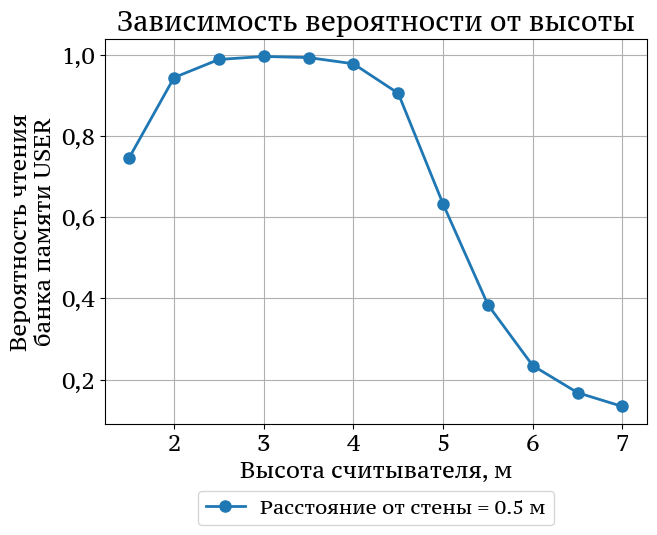

In [51]:
plot_simulations_results(
    results_list=[altitude_results["read_user_probs"]],
    labels_list=[key_name(params) for params in offset_params],
    titles=["Зависимость вероятности от высоты"],
    x_variable=altitudes,
    x_label="Высота считывателя, м",
    image_name="Altitude probs",
    save_fig=SAVE_FIG,
    image_directory=IMG_DIRECTORY,
)

### 🖼️ Построение графика для времени чтения банка памяти USER

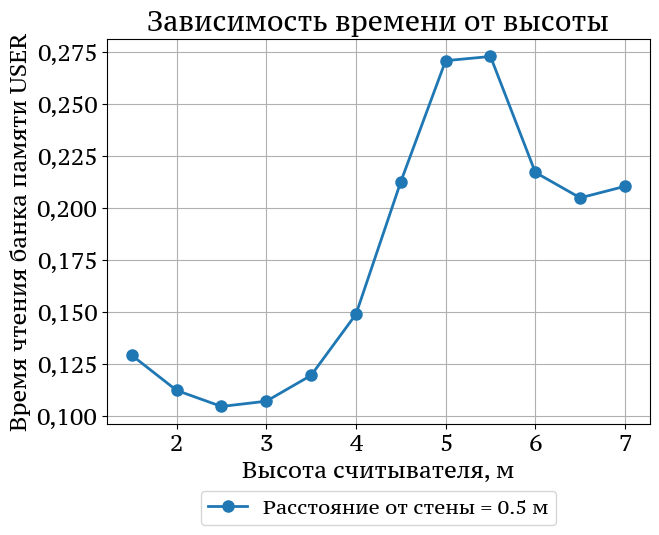

In [52]:
plot_simulations_results(
    results_list=[altitude_results["times_count"]],
    labels_list=[key_name(params) for params in offset_params],
    titles=["Зависимость времени от высоты"],
    x_variable=altitudes,
    x_label="Высота считывателя, м",
    y_label="Время чтения банка памяти USER",
    image_name="Altitude times",
    save_fig=True,
    image_directory=IMG_DIRECTORY,
)

## 📈 Зависимость вероятности чтения банка памяти `USER` от мощности считывателя

В этом эксперименте изучается, как **мощность сигнала считывателя (`power`)** влияет на вероятность успешного чтения данных из банка `USER`.

🔍 **Вариации параметров:**
- Переменная `power` изменяется от **19.0 до 31.5 дБм** с шагом 0.5 дБм.
- Построены кривые для **четырёх высот полёта считывателя**:  
  `1 м`, `3 м`, `5 м`, `7 м`.

📌 Остальные параметры модели (скорость, смещение от стены, тип модуляции и т.д.) — фиксированы.

📉 Каждая кривая показывает, как изменение мощности считывателя влияет на вероятность чтения при заданной высоте полёта.

### ⚙️ Параметры для запуска моделирования

In [ ]:
# Переменная по оси абсцисс
powers = np.arange(19.0, 32.0, 0.5)
# Параметры для разных кривых
altitude_params = [
    {"altitude": 1},
    {"altitude": 3},
    {"altitude": 5},
    {"altitude": 7},
]

# Каждый словарь в list - это набор входных данных для одной кривой
power_params_list = []
for alt in altitude_params:
    power_params_list.append({
        "tari": default_params.tari,
        "encoding": default_params.encoding,
        "tid_word_size": default_params.tid_word_size,
        # "num_tags": default_params.num_tags,
        "num_tags": 50,
        "speed": default_params.speed,
        "reader_offset": default_params.reader_offset,
        "tag_offset": default_params.tag_offset,
        "altitude": alt["altitude"],
        "useadjust": default_params.useadjust,
        "q": default_params.q,
    })

### 💾 Получение результатов

In [ ]:
key_name = lambda params: f"Высота полёта = {params['altitude']} м"

In [ ]:
power_results = calculate_simulations(
    variable='power',
    variable_values=powers,
    params_list=power_params_list,
    key_fn=key_name,
    use_json=USE_JSON,
    save_results=SAVE_RESULTS,
    json_directory=JSON_DIRECTORY,
    file_name="power.json"
)
# Моделирование на M3 Pro с 'num_tags': 750:
# Моделирование по мощности: 100%|██████████| 4/4 [09:42<00:00, 145.58s/it]

### 🖼️ Построение графика

In [ ]:
plot_simulations_results(
    results_list=[power_results],
    labels_list=[key_name(p) for p in altitude_params],
    titles=["Зависимость вероятности от мощности считывателя"],
    x_variable=powers,
    x_label="Мощность считывателя, dBm",
    image_name="Power probs",
    save_fig=SAVE_FIG,
    image_directory=IMG_DIRECTORY,
)

## 📈 Зависимость вероятности чтения банка памяти `USER` от его величины (в байтах)
В этом эксперименте исследуется, как **размер блока данных, считываемого с метки (`tid_word_size`)**, влияет на вероятность успешного чтения.

🧪 **Параметр `tid_word_size`** задаёт длину блока USER или TID (в зависимости от конфигурации модели) в битах. Модель позволяет варьировать этот параметр от 16 до 256 бит.

### 🔬 Эксперимент состоит из двух серий:

1. **📡 Первая серия:** каждая кривая соответствует **разной мощности сигнала считывателя**:  
   `27`, `29`, `31.5 дБм`.
   
2. **⚙️ Вторая серия:** каждая кривая строится для своей **пары параметров Tari и M**:
   - M = `FM0`, Tari = 6.25 мкс
   - M = `FM0`, Tari = 18.75 мкс
   - M = `Miller-2`, Tari = 12.5 мкс
   - M = `Miller-4`, Tari = 6.25 мкс
   - M = `Miller-8`, Tari = 25.0 мкс

📌 Остальные параметры (высота, скорость, смещение и т.д.) фиксированы.

📉 Каждая точка на графике получается в результате запуска отдельной имитационной модели. Каждая кривая — результат **одного сета моделирования**.

### ⚙️ Параметры для запуска моделирования

In [ ]:
tid_lengths = list(range(16, 257, 16))

# Для первой серии экспериментов ------------------------------------
power_params = [
    {'power': 27},
    {'power': 29},
    {'power': 31.5},
]

# Каждый словарь в list - это набор входных данных для одной кривой
length_params_list_1_exp = []
for power in power_params:
    length_params_list_1_exp.append({
        'tari': default_params.tari,
        'encoding': default_params.encoding,
        'power': power['power'],
        # 'num_tags': default_params.num_tags,
        'num_tags': 500,
        'speed': default_params.speed,
        'reader_offset': default_params.reader_offset,
        'tag_offset': default_params.tag_offset,
        'altitude': default_params.altitude,
        'useadjust': default_params.useadjust,
        'q': default_params.q,
    })

In [ ]:
# Для второй серии экспериментов ------------------------------------
coding_params = [
    {'encoding': 'FM0', 'tari': 6.25},
    {'encoding': 'FM0', 'tari': 18.75},
    {'encoding': 'M2', 'tari': 12.5},
    {'encoding': 'M4', 'tari': 6.25},
    {'encoding': 'M8', 'tari': 25.0},
]

# Каждый словарь в list - это набор входных данных для одной кривой
length_params_list_2_exp = []
for coding_params_item in coding_params:
    length_params_list_2_exp.append({
        'tari': coding_params_item['tari'],
        'encoding': coding_params_item['encoding'],
        'power': default_params.power_dbm,
        # 'num_tags': default_params.num_tags,
        'num_tags': 1000,
        'speed': default_params.speed,
        'reader_offset': default_params.reader_offset,
        'tag_offset': default_params.tag_offset,
        'altitude': default_params.altitude,
        'useadjust': default_params.useadjust,
        'q': default_params.q,
    })

### 💾 Получение результатов

In [ ]:
key_name = lambda params: f"Мощность = {params['power']} дБм"
key_name_2 = lambda params: f"M = {params['encoding']}, Tari = {params['tari']} мкс"

In [ ]:
length_results_1_exp = calculate_simulations(
    variable="tid_word_size",
    variable_values=tid_lengths,
    params_list=length_params_list_1_exp,
    key_fn=key_name,
    use_json=USE_JSON,
    save_results=SAVE_RESULTS,
    json_directory=JSON_DIRECTORY,
    file_name="length_1.json"
)
# Моделирование на M3 Pro с 'num_tags': 1000:
# Моделирование по длине пакета: 100%|██████████| 3/3 [04:56<00:00, 98.89s/it] 

In [ ]:
length_results_2_exp = calculate_simulations(
    variable="tid_word_size",
    variable_values=tid_lengths,
    params_list=length_params_list_2_exp,
    key_fn=key_name_2,
    use_json=USE_JSON,
    save_results=SAVE_RESULTS,
    json_directory=JSON_DIRECTORY,
    file_name="length_2.json"
)
# Моделирование на M3 Pro с 'num_tags': 1000:
# Моделирование по переменной tid_word_size: 100%|██████████| 5/5 [10:33<00:00, 126.60s/it]

### 🖼️ Построение графиков

In [ ]:
plot_simulations_results(
    results_list=[length_results_1_exp, length_results_2_exp],
    labels_list=[
        [key_name(params) for params in power_params],
        [key_name_2(params) for params in coding_params],
    ],
    titles=[
        "Вероятность от длины банка USER\nдля разных мощностей считывателя",
        "Вероятность от длины банка USER\nдля разных Tari и M"
    ],
    x_variable=tid_lengths,
    x_label="Размер передаваемого блока USER, бит",
    image_name="Length probs",
    save_fig=SAVE_FIG,
    image_directory=IMG_DIRECTORY,
)

## 📈 Зависимость вероятности чтения банка памяти `USER` от расстояния метки от стены
В этом эксперименте изучается, как **горизонтальное смещение метки (`tag_offset`)** влияет на вероятность успешного чтения информации из банка `USER`.

📏 **Вариации параметров:**
- Переменная `tag_offset` изменяется от **0.25 до 2.75 м** с шагом 0.25 м.
- Рассматриваются три разных **высоты полёта БПЛА со считывателем**:
  1. 1 м
  2. 2 м
  3. 3 м

📌 Остальные параметры фиксированы, включая:
- `reader_offset = 1.5 м` — расстояние от стены до считывателя,
- `tid_word_size = 64 слова`,
- `power = 29 дБм`,
- `скорость = 50 км/ч`.

📉 Каждая кривая на графике отражает, как изменяется вероятность чтения с ростом расстояния от метки до стены при фиксированной высоте считывателя.

### ⚙️ Параметры для запуска моделирования

In [ ]:
# Значения переменной по оси абсцисс
tag_offsets = np.arange(0.25, 3.0, 0.25)  # от 0.25 до 2.75 с шагом 0.25

# Разные высоты полёта БПЛА
altitude_params = [
    {'altitude': 3},
    {'altitude': 4},
    {'altitude': 5},
]

# Каждый словарь в list - это набор входных данных для одной кривой
tag_offset_params_list = []
for alt in altitude_params:
    tag_offset_params_list.append({
        'tari': default_params.tari,
        'encoding': default_params.encoding,
        'tid_word_size': default_params.tid_word_size,
        'power': default_params.power_dbm,
        'num_tags': 2000,
        'speed': default_params.speed*2,
        'reader_offset': 1.5,
        'altitude': alt['altitude'],
        'useadjust': default_params.useadjust,
        'q': default_params.q,
    })

### 💾 Получение результатов

In [ ]:
key_fn = lambda params: f"Высота = {params['altitude']} м"

In [ ]:
tag_offset_results = calculate_simulations(
    variable="tag_offset",
    variable_values=tag_offsets,
    params_list=tag_offset_params_list,
    key_fn=key_fn,
    use_json=USE_JSON,
    save_results=SAVE_RESULTS,
    json_directory=JSON_DIRECTORY,
    file_name="tag_offset.json"
)

# Моделирование на M3 Pro с 'num_tags': 2000:
# Моделирование по переменной tag_offset: 100%|██████████| 3/3 [06:45<00:00, 135.23s/it]

### 🖼️ Построение графика

In [ ]:
plot_simulations_results(
    results_list=[tag_offset_results],
    labels_list=[key_fn(p) for p in altitude_params],
    titles=[
        "Вероятность от удаления метки от стены\n"
        f"для скорости = {tag_offset_params_list[0]['speed']} км/ч\n"
        f"и reader_offset = {tag_offset_params_list[0]['reader_offset']} м"
    ],
    x_variable=tag_offsets,
    x_label="Удаление от стены, м",
    image_name="Tag offset probs",
    image_directory=IMG_DIRECTORY,
    save_fig=SAVE_FIG
)